In [2]:
import mne
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

In [4]:
subjects = []
directory_path="./preprocessed_data/"

for i in range(1, 36):
    try:
        filename = f"processed_psd_sub-{i:02d}.pkl"
        path = directory_path + filename
        sub = pd.read_pickle(path)
        subjects.append(sub)
    except (RuntimeError, TypeError, NameError, FileNotFoundError):
        print(f"sub-{i:02d} file has an error")
        pass
    
df = pd.concat(subjects)
del subjects

frequency_bins = df["freq"].unique()

sub-08 file has an error
sub-09 file has an error
sub-10 file has an error
sub-11 file has an error
sub-12 file has an error
sub-13 file has an error
sub-14 file has an error
sub-15 file has an error
sub-16 file has an error
sub-18 file has an error
sub-19 file has an error
sub-20 file has an error
sub-21 file has an error
sub-22 file has an error
sub-23 file has an error
sub-24 file has an error
sub-25 file has an error
sub-26 file has an error
sub-27 file has an error
sub-28 file has an error
sub-29 file has an error
sub-30 file has an error
sub-31 file has an error
sub-32 file has an error
sub-33 file has an error
sub-34 file has an error
sub-35 file has an error


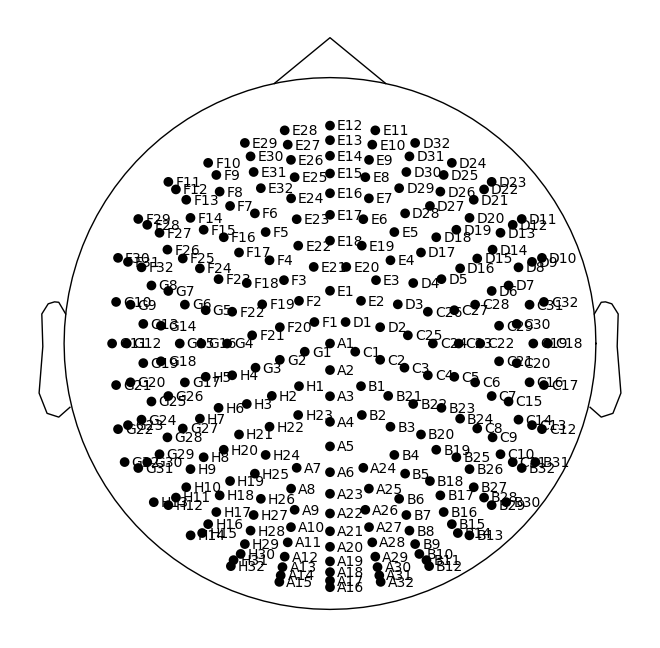

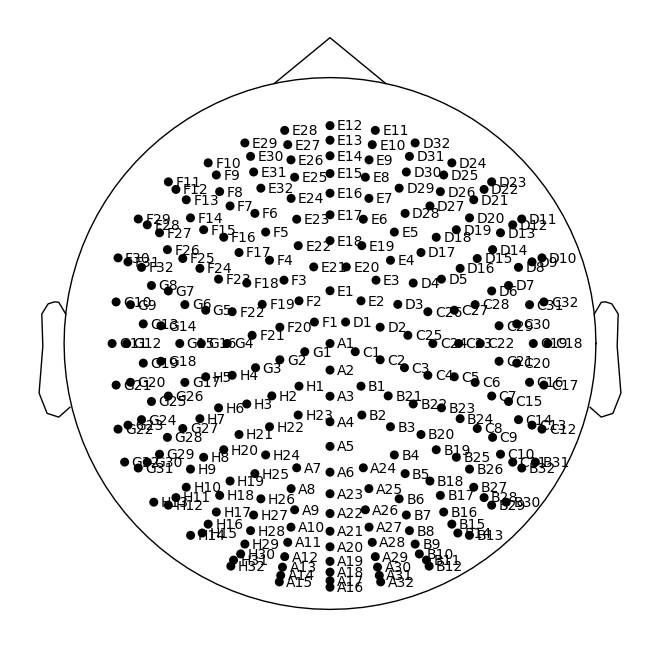

In [26]:
biosemi_montage = mne.channels.make_standard_montage('biosemi256')

biosemi_montage.get_positions()

biosemi_montage.plot()

In [5]:

frontal_channels = [
    "F10",
    "E29", 
    "E28", 
    "E11", 
    "E12", 
    "D32", 
    "D24", 
    "D25", 
    "D31", 
    "E10", 
    "E13", 
    "E27", 
    "E30", 
    "F9"
]

positive_emotions = {
    "awe",
    "compassion",
    "content",
    "excite",
    "happy",
    "joy",
    "love",
    "relief",
}

negative_emotions = {
    "anger",
    "disgust",
    "fear",
    "frustration",
    "grief",
    "jealousy",
    "sad"
}

In [6]:
df["valence"] = df["emotion"].apply(lambda x : "+" if x in positive_emotions else "-")

In [7]:
epochs = df["epoch"].unique()
processed_epochs = []

for epoch in epochs:
    epoch_dict = {}
    channels_series = {}
    df_epoch = df.loc[df["epoch"] == epoch, ("value", "valence", "channel")]

    for channel in frontal_channels:
        series = np.array(df_epoch.loc[
            df_epoch["channel"] == channel, "value"
        ])
        if len(series) > 0:
            channels_series[channel] = series
    
    epoch_dict["channels"] = channels_series
    epoch_dict["valence"] = str(df_epoch.iloc[0]["valence"])
    processed_epochs.append(epoch_dict)


In [8]:
# Delete the original dataframe for performance.

del df

In [9]:
def get_frequency_bands_features(power_spectrum_dict):
    frequency_bands = {
        'alpha': (8, 13),
        'beta': (13, 30),
        'theta': (4, 8),
        'delta': (0.5, 4),
        'gamma': (30, 40)
    }

    transformed_dict = {}

    for band, (f_min, f_max) in frequency_bands.items():
        indices = np.where(np.logical_and(frequency_bins >= f_min, frequency_bins <= f_max))
        channel_means = []
        channel_stddevs = []

        for _, power_spectrum in power_spectrum_dict.items():
            power_values = power_spectrum[indices]
            channel_means.append(np.nanmean(power_values))
            channel_stddevs.append(np.nanstd(power_values))

        transformed_dict[f"{band}_mean"] = np.mean(channel_means)
        transformed_dict[f"{band}_stddev"] = np.mean(channel_stddevs)

    return transformed_dict

In [10]:
features_dict = []

for idx, epoch in enumerate(processed_epochs):
    features_dict.append({
        "valence": epoch["valence"],
        **get_frequency_bands_features(epoch["channels"])
    })

df_processed = pd.DataFrame(features_dict)
df_processed

,valence,alpha_mean,alpha_stddev,beta_mean,beta_stddev,theta_mean,theta_stddev,delta_mean,delta_stddev,gamma_mean,gamma_stddev
0,+,6.708525e-10,5.101992e-10,2.396946e-10,2.260534e-10,1.536764e-09,3.592209e-10,1.219014e-09,2.973887e-10,3.928875e-11,1.656844e-11
1,+,3.854445e-10,2.236984e-10,2.107650e-10,1.577168e-10,8.516365e-10,1.851201e-10,1.392824e-09,3.584204e-10,4.194206e-11,2.263298e-11
2,+,3.239599e-10,6.523589e-11,2.150017e-10,1.625673e-10,6.312605e-10,1.125875e-10,1.376286e-09,3.701379e-10,4.107593e-11,1.557431e-11
3,+,5.023116e-10,2.264501e-10,1.839557e-10,1.390440e-10,8.572610e-10,1.936632e-10,8.947341e-10,2.540820e-10,4.281888e-11,1.208250e-11
4,+,6.481647e-10,3.179918e-10,2.443792e-10,1.980991e-10,1.422986e-09,3.312725e-10,7.354928e-10,2.204857e-10,4.499966e-11,1.800204e-11
...,...,...,...,...,...,...,...,...,...,...,...
544,+,8.572079e-10,3.064499e-10,1.677877e-10,6.731019e-11,3.924386e-10,1.711411e-10,1.034559e-09,3.672976e-10,7.857811e-11,2.153503e-11
545,+,1.105921e-09,6.173329e-10,1.478942e-10,6.695294e-11,5.016938e-10,2.102582e-10,1.260315e-09,6.601331e-10,1.150053e-10,5.006240e-11
546,+,1.134289e-09,4.620477e-10,2.023945e-10,1.058795e-10,5.000646e-10,1.501523e-10,1.064731e-09,2.876998e-10,8.717451e-11,3.087586e-11
547,+,1.524196e-09,8.209112e-10,2.078196e-10,1.088184e-10,3.779696e-10,1.315748e-10,9.282658e-10,2.909913e-10,1.287252e-10,4.006670e-11


In [11]:
#Scale it by a factor of 10^10 since the model doesn't perform well with low values. 

df_processed[df_processed.select_dtypes(include=['number']).columns] *= 10e10

/tmp/ipykernel_16135/3292569828.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_processed.corr(), cmap="YlGnBu", annot=True)


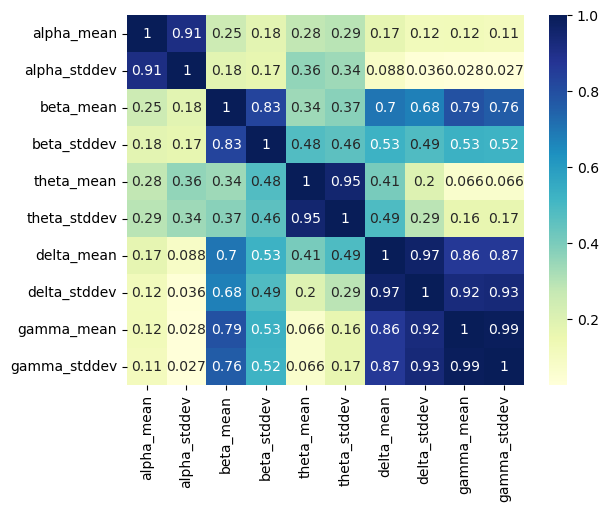

In [12]:
sns.heatmap(df_processed.corr(), cmap="YlGnBu", annot=True)
plt.show()
plt.close()

[0.91522842 0.07244219 0.00721398]


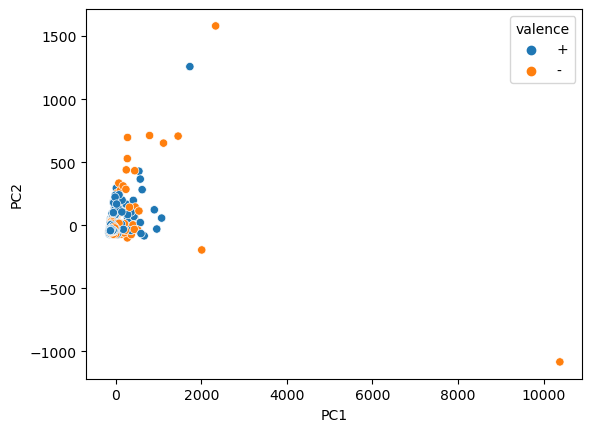

In [13]:
# We compute a PCA to get a graph of the information.

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
 
pca.fit(df_processed.iloc[:, 1:])
 
pca_trans = pca.transform(df_processed.dropna(axis=1).iloc[:, 1:])
pca_df = pd.DataFrame(data = pca_trans, columns = ["PC1", "PC2", "PC3"])
pca_df["valence"] = df_processed["valence"]

print(pca.explained_variance_ratio_)

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="valence")
plt.show()
plt.close()

In [57]:
# We conserve only the means, since the mean and standard deviation of each band
# are highly correlated. Except for the beta_sttdev

feed_data = df_processed.loc[:, ("alpha_mean", "beta_mean", "beta_stddev", "theta_mean", "delta_mean", "gamma_mean", "valence")]

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    feed_data.drop("valence", axis=1), feed_data["valence"], test_size=0.2, random_state=42
)

In [63]:
# Hyperparameter tuning

param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [7, 10, 15, 20],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 150, 200]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)
# Instantiate the grid search model
search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 300, cv = 3, verbose=2, random_state=42, n_jobs = -1)

search.fit(X_train, y_train)
search.best_params_

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV] END criterion=log_loss, max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END criterion=entropy, max_depth=7, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=150; total time=   0.5s
[CV] END criterion=entropy, max_depth=7, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=150; total time=   0.5s
[CV] END criterion=log_loss, max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.8s
[CV] END criterion=log_loss, max_depth=15, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200; total time=   0.6s
[CV] END criterion=log_loss, max_depth=20, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END criterion=entropy, max_depth=20, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_features': 2,
 'max_depth': 20,
 'criterion': 'log_loss'}

In [73]:
rf = RandomForestClassifier(
    random_state = 42, 
    n_estimators=200, 
    min_samples_split=8, 
    min_samples_leaf=3, 
    max_depth=20,
    criterion='log_loss'
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [74]:
accuracy_score(y_test, y_pred)

0.6545454545454545

In [62]:
rf.feature_importances_

array([0.16193749, 0.16667577, 0.14986726, 0.1745041 , 0.14943688,
       0.1975785 ])

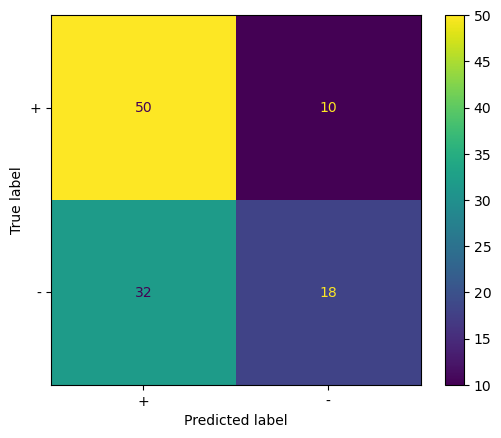

In [43]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=rf.classes_)
disp.plot()